In [121]:
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
Image(url='http://datascience.uci.edu/wp-content/uploads/sites/2/2014/09/data_science_logo_with_image1.png')
%matplotlib inline

## Predictive Modeling with Python - _Linear Methods for Classification_
#### Author: Eric Nalisnick

### Goals of this Lesson
 
- Extend the Regression Framework for Classification Purposes
    - Motivation
    - Gradient Descent for Logistic Regression
- Demonstrate Python 
    - Code Stochastic Gradient Descent and Newton's Method
    - Perform Logistic Regression in Sci-Kit Learn
        - Specialized packages in python


### References for Logistic Regression

- Elements of Statistical Learning - Chapter 4 by Hastie, Tibshriani, Friedman
- scikit-learn Documentation - http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

### Classes as Targets

Now that we've seen how to train and evaluate a linear model of real-valued responses, next we turn to classification.  At first glance, the jumping from regression to classification seems trivial.  Say there are two classes, the first denoted by 0 and the second by 1.  We could just appropriately set the $y_{i}$'s to 0 or 1 and fit a linear model just as before.

_** Here's an artifical example doing just that... **_

Classification Error on Training Set: 33.00%


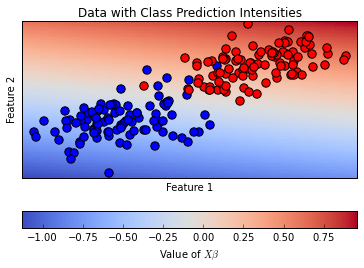

In [134]:
# A somewhat complicated function to make pretty plots
def plot_classification_data(data1, data2, beta, logistic_flag=False):
    plt.figure()
    grid_size = .2
    features = np.vstack((data1, data2))
    # generate a grid over the plot
    x_min, x_max = features[:, 0].min() - .5, features[:, 0].max() + .5
    y_min, y_max = features[:, 1].min() - .5, features[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_size), np.arange(y_min, y_max, grid_size))
    # colors the grid based on predictions for that space
    if logistic_flag:
        Z = logistic(np.dot(np.c_[xx.ravel(), yy.ravel()], beta))
        colorbar_label=r"Value of f($X \beta)$"
    else:
        Z = np.dot(np.c_[xx.ravel(), yy.ravel()], beta)
        colorbar_label=r"Value of $X \beta$"
    Z = Z.reshape(xx.shape)
    background_img = plt.pcolormesh(xx, yy, Z, cmap=plt.cm.coolwarm)
    
    # Also plot the training points
    plt.scatter(class1_features[:, 0], class1_features[:, 1], c='b', edgecolors='k', s=70)
    plt.scatter(class2_features[:, 0], class2_features[:, 1], c='r', edgecolors='k', s=70)
    plt.title('Data with Class Prediction Intensities')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    color_bar = plt.colorbar(background_img, orientation='horizontal')
    color_bar.set_label(colorbar_label)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.show()

# shuffle the data and labels
def shuffle_in_unison(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    
# calculate classification errors
def calc_classification_error(predictions, class_labels):
    n = predictions.size
    num_of_errors = 0.
    for idx in xrange(n):
        if (predictions[idx] >= 0.5 and class_labels[idx]==0) or (predictions[idx] < 0.5 and class_labels[idx]==1):
            num_of_errors += 1
    return num_of_errors/n
    
# create artificial data
N = 200
p = 2
mean1 = [-3,-3]
mean2 = [3,3]
covariance = [[2.5,1],[1,3]]
# Sample the features from a MVN
class1_features = np.random.multivariate_normal(mean1,covariance,N/2)
class2_features = np.random.multivariate_normal(mean2,covariance,N/2)
features = np.vstack((class1_features, class2_features))
# Set the class labels
class1_labels = [0]*(N/2)
class2_labels = [1]*(N/2)
class_labels = class1_labels+class2_labels
shuffle_in_unison(features, class_labels)
class_labels = np.array(class_labels)[np.newaxis].T

# fit the linear model
beta = np.dot(np.linalg.inv(np.dot(features.T, features)),np.dot(features.T,class_labels))

# compute error on training data
predictions = np.dot(features, beta)
print "Classification Error on Training Set: %.2f%%" %(calc_classification_error(predictions, class_labels) * 100)

# generate the plot
plot_classification_data(class1_features, class2_features, beta)


That worked just fine.  However, it seems a bit arbitary to set the class labels to 0 vs. 1.  Why couldn't we have set them to -1 vs. +1?  Or -500 vs. 230?  Furthermore, our model is optimizing squarred error, but we are quantifying classification error as a percentage.  What does distance mean if we want to quantify class membership or not?

Let's consider a different loss function:
\begin{eqnarray*}
\mathcal{L} = \sum_{i=1}^{N} -y_{i} \log \hat y_{i} - (1-y_{i}) \log (1-\hat y_{i})
\end{eqnarray*}
where $\hat y_{i}$ is our model's prediction of label $y_{i} \in \{0,1\}$.  This is called the 'cross-entropy error function.'  Notice it's more suited for classification than squarred error in that we are now optimizing directly towards $0$ and $1$ instead of $-\infty$ and $+\infty$.

> Advanced Note: Cross-entroy loss still may seem arbitrary to some readers.  It is derived by taking the negative logarithm of the Bernoulli distribution's density function, which has support {0,1}.  Therefore, we can think of each class label as the result of a Bernoulli trial--a parameterized coin flip, essentially.  Many loss functions are merely the negative logarithm of some probability density function.  Squarred error is derived by taking the $-\log$ of the Normal density funciton.

### Modifying the Linear Model

Now that we have our loss function and proper labels, we turn to the model itself, represented by the parameter $\hat y$ above.  What if we keep it the same as the regression setting?
\begin{equation*}
\hat y = \beta_0 + \beta_1 x_1 + \dots + \beta_p x_p = X_i^T\beta
\end{equation*}
Notice parameterizing $\hat y$ with $x_i^T\beta$ doesn't work since the value would be unconstrained and result in the loss being undefined if $\hat y\le 0$ or $\hat y \ge 1$.  Thus, we need a function $f$ such that $f:\mathbb{R} \mapsto (0,1)$.  Can you think of a class of functions that feature this behavior?  Cumulative Distribution Functions fit the bill.  In this case, we can use any CDF as long as it has support on $(-\infty, +\infty)$ since this is the range of $X_i^T\beta$.

Choosing which CDF to use can be a hard decision since each choice drags along assumptions we don't have time to go into here.  We'll choose the Logistic Distribution's CDF:
\begin{equation*}
f(z; 0, 1) = \frac{1}{1+e^{-z}}.
\end{equation*}
Tradition partly dictates this choice, but it does provide the nice interpretation that $x_i^T\beta$ is modeling the 'log odds':

\begin{eqnarray*}
\log \frac{\hat y}{1-\hat y} &=& \log \frac{f(z; 0, 1)}{1-f(z; 0, 1)} \\ &=& \log f(z; 0, 1) - \log (1-f(z; 0, 1) )\\ &=& -\log (1+e^{-z}) - \log (1-(1+e^{-z})^{-1}) \\ &=& -\log (1+e^{-z}) - \log e^{-z} + \log (1+e^{-z}) \\ &=&  - \log e^{-z} \\ &=& z   \\ &=& X_i^T\beta  \end{eqnarray*} 

This use of the Logistic Distribution is where Logistic Regression gets its name.  As a side note before proceeding, using the Normal CDF instead of the Logistic is called 'Probit Regression,' the second most popular regression framework.  


### Logistic Regression

_**Data**_

We observe pairs $(x_{i},y_{i})$ where
\begin{eqnarray*}
y_{i} \in \{ 0, 1\} &:& \mbox{class label} \\
X_{i} = (1, x_{i,1}, \dots, x_{i,p}) &:& \mbox{set of $p$ explanatory variables (aka features) and a bias term } 
\end{eqnarray*}

_** Parameters**_

\begin{eqnarray*}
\beta = (\beta_{i,0}, \dots, \beta_{i,p}) : \mbox{values encoding the relationship between the features and label}
\end{eqnarray*}

_** Transormation Function **_
\begin{equation*}
f(z=X_{i}\beta) = (1+e^{-X_{i}\beta})^{-1}
\end{equation*}

_**Error Function**_

\begin{eqnarray*}
\mathcal{L} = \sum_{i=1}^{N} -y_{i} \log f(X_{i}\beta) - (1-y_{i}) \log (1-f(X_{i}\beta))
\end{eqnarray*}

_** Learning $\beta$ **_

Like Linear Regression, learning a Logistic Regression model will entail minimizing the error function $\mathcal{L}$ above.  Can we solve for it in closed form?  Let's look at the derivative of $\mathcal{L}$ with respect to $\beta$:

\begin{eqnarray*}
\frac{\partial \mathcal{L}}{\partial \beta} &=& \frac{\partial \mathcal{L}}{\partial f(z)} \frac{\partial f(z)}{\partial z} \frac{\partial z}{\partial \beta}\\
&=& \left[\frac{-y_{i}}{f(X_{i}\beta)} - \frac{y_{i}-1}{1-f(X_{i}\beta)} \right] f(X_{i}\beta)(1-f(X_{i}\beta))X_{i}\\
&=& [-y_{i}(1-f(X_{i}\beta)) - (y_{i}-1)f(X_{i}\beta)]X_{i}\\
&=& [f(X_{i}\beta) - y_{i}]X_{i}
\end{eqnarray*}

We see that the first derivative contains the term $f(X_{i}\beta)$, meaning the gradient depends on $\beta$ in some non-linear way.  We have no choice but to use the Gradient Descent algorithm:
- Randomly initialize $\beta$
- Until $\alpha || \nabla_{\beta} \mathcal{L} || < tol $:
    - $\beta_{t+1} = \beta_{t} - \alpha \nabla_{\beta} \mathcal{L}$


_** Putting it all together in a simple example... **_  


Training ended after 5000 iterations, taking a total of 3.66 seconds.
Final Cross-Entropy Error: 2895.64
Classification Error on Training Set: 2.50%


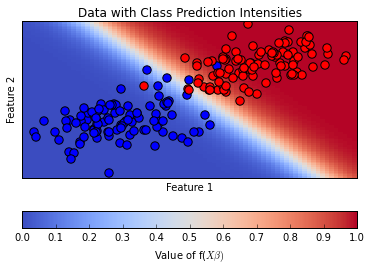

In [135]:
# define the transformation function
def logistic(z):
    return np.power((1+np.exp(-z)),-1)

# Randomly initialize the Beta vector
beta = np.random.multivariate_normal([0,0], [[1,0],[1,0]], 1).T
# Initialize the step-size
alph = 0.01
# Set the tolerance 
tol = 1e-6
# Initialize error
old_error = 0
error = [np.infty]

# Run Gradient Descent
start_time = time.time()
iter_idx = 1
while (abs(old_error-error[-1]) > tol) and (iter_idx < 5000):
    f = logistic(np.dot(features,beta))
    old_error = error[-1]
    error.append(np.sum(-1*np.multiply(class_labels,np.log(f)) - np.multiply((np.ones(N)-class_labels),np.log(np.ones(N)-f)))) 
    grad = np.mean(np.multiply(f-class_labels,features),0)[np.newaxis].T
    beta = beta - alph*grad
    iter_idx += 1
end_time = time.time()
print "Training ended after %i iterations, taking a total of %.2f seconds." %(iter_idx, end_time-start_time)
print "Final Cross-Entropy Error: %.2f" %(error[-1])

# compute error on training data
predictions = logistic(np.dot(features, beta))
print "Classification Error on Training Set: %.2f%%" %(calc_classification_error(predictions, class_labels) * 100)

# generate the plot
plot_classification_data(class1_features, class2_features, beta, logistic_flag=True)

### Newton's Method

Choosing the step-size, $\alpha$, can be painful since there is no principled way to set it.  We have little intuition for what parameter space really looks like and therefore no sense of how to move most efficiently.  Knowing the curvature of the space will solve this problem (to some extent).  Therefore, we arrive at Newton's Method:
\begin{equation*}
\beta_{t+1} = \beta_{t} - (\frac{\partial^{2} \mathcal{L}}{\partial \beta \partial \beta^{T}})^{-1} \nabla_{\beta} \mathcal{L}
\end{equation*}

where $(\frac{\partial^{2} \mathcal{L}}{\partial \beta \partial \beta^{T}})^{-1}$ is the inverse of the matrix of second derivatives, also known as the Hessian Matrix.  For logistic regression, the Hessian is
\begin{equation*}
\frac{\partial^{2} \mathcal{L}}{\partial \beta \partial \beta^{T}} = -\mathbf{X}^{T}\mathbf{A}\mathbf{X}
\end{equation*}

where $\mathbf{A}= \mathrm{diag}(f(X_{i}\beta)(1-f(X_{i}\beta)))$, a matrix with $f''$ along its diagonal.

Our new parameter update is:
\begin{eqnarray*}
\beta_{t+1} &=& \beta_{t} + (\mathbf{X}^{T}\mathbf{A}\mathbf{X})^{-1}[f(\mathbf{X}\beta) - \mathbf{y}]\mathbf{X}
\end{eqnarray*}



_** Let's try Newton's Method on our simple example... **_ 

Training ended after 2221 iterations, taking a total of 1.77 seconds.
Final Cross-Entropy Error: 2872.00
Classification Error on Training Set: 2.50%


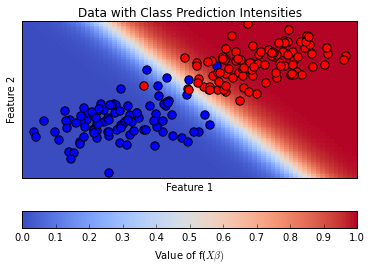

In [136]:
# Save the errors from run above
no_Newton_errors = error

# Randomly initialize the Beta vector
beta = np.random.multivariate_normal([0,0], [[1,0],[1,0]], 1).T
# Initialize error
old_error = 0
error = [np.infty]

# Run Gradient Descent
start_time = time.time()
iter_idx = 1
while (abs(old_error-error[-1]) > tol) and (iter_idx < 5000):
    f = logistic(np.dot(features,beta))
    old_error = error[-1]
    error.append(np.sum(-1*np.multiply(class_labels,np.log(f)) - np.multiply((np.ones(N)-class_labels),np.log(np.ones(N)-f)))) 
    grad = np.mean(np.multiply(f-class_labels,features),0)[np.newaxis].T
    # create matrix of f''
    A = np.multiply(f,np.ones(N)[np.newaxis].T-f)
    # just duplicate the rows, cheaper than the full diagonal
    A = np.hstack((A,A))
    Hessian = np.dot(np.multiply(features, A).T, features)
    beta = beta - np.dot(np.linalg.inv(Hessian),grad)
    iter_idx += 1
end_time = time.time()
print "Training ended after %i iterations, taking a total of %.2f seconds." %(iter_idx, end_time-start_time)
print "Final Cross-Entropy Error: %.2f" %(error[-1])

# compute the classification error on training data
predictions = logistic(np.dot(features, beta))
print "Classification Error on Training Set: %.2f%%" %(calc_classification_error(predictions, class_labels) * 100)

# generate the plot
plot_classification_data(class1_features, class2_features, beta, logistic_flag=True)

Let's look at the training progress for the models trained with and without Newton's method.

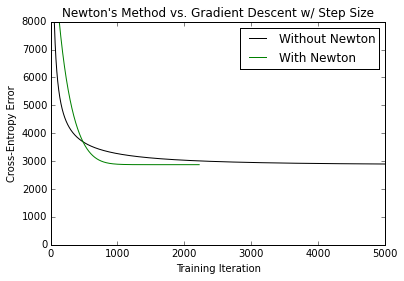

In [138]:
# plot difference between with vs without Newton
plt.figure()
# grad descent w/ step size
plt.plot(range(len(no_Newton_errors)), no_Newton_errors, 'k-', label='Without Newton')
# newton's method
plt.plot(range(len(error)), error, 'g-', label='With Newton')
plt.ylim([0,8000])
plt.legend()
plt.title("Newton's Method vs. Gradient Descent w/ Step Size")
plt.xlabel("Training Iteration")
plt.ylabel("Cross-Entropy Error")
plt.show()

## Logistic Regression with SciKit-Learn 

Here is the documentation for SciKit-Learn's implementation of Logistic Regression:  
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

It's very easy to use.  Let's repeat the above experiments.

Training ended after 0.00 seconds.
Classification Error on Training Set: 1.50%


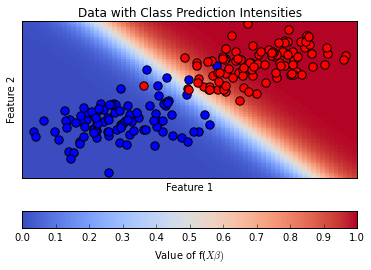

In [139]:
from sklearn.linear_model import LogisticRegression

#Initialize the model
skl_LogReg = LogisticRegression()

#Train it
start_time = time.time()
skl_LogReg.fit(features, np.ravel(class_labels))
end_time = time.time()
print "Training ended after %.2f seconds." %(end_time-start_time)

# compute the classification error on training data
predictions = skl_LogReg.predict(features)
print "Classification Error on Training Set: %.2f%%" %(calc_classification_error(predictions, class_labels) * 100)

# generate the plot
plot_classification_data(class1_features, class2_features, skl_LogReg.coef_.T, logistic_flag=True)

## Experiments

### Dataset #1: NBA Shot Outcomes

The first real dataset we'll tackle is one describing the location and outcome of shots taken in professional basketball games.  Let's use Pandas to load and examine the data.    

In [140]:
nba_shot_data = pd.read_csv('./data/NBA_xy_features.csv')
print nba_shot_data.head()
print
print nba_shot_data.describe()

   x_Coordinate  y_Coordinate  shot_outcome
0            26            32             0
1            25            24             0
2            25             6             1
3            40             7             1
4            12            13             1

        x_Coordinate   y_Coordinate   shot_outcome
count  562538.000000  562538.000000  562538.000000
mean       25.178772      13.496301       0.458145
std        11.212500       8.651198       0.498246
min        -3.000000       1.000000       0.000000
25%        19.000000       6.000000       0.000000
50%        25.000000      10.000000       0.000000
75%        31.000000      21.000000       1.000000
max        51.000000      94.000000       1.000000


Simple enough.  Now let's train a Logistic Regression model on it, leaving out a test set.

Training ended after 0.57 seconds.
Classification Error on the Test Set: 41.87%


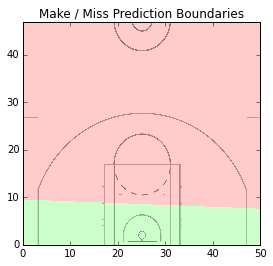

In [141]:
# Another messy looking function to make pretty plots
from matplotlib.colors import ListedColormap
def visualize_court(log_reg_model, court_image = './data/nba_court.jpg'):
    two_class_cmap = ListedColormap(['#FFAAAA', '#AAFFAA']) # light red for miss, light green for make
    x_min, x_max = 0, 50 #width (feet) of NBA court
    y_min, y_max = 0, 47 #length (feet) of NBA half-court
    grid_step_size = 0.2
    grid_x, grid_y = np.meshgrid(np.arange(x_min, x_max, grid_step_size), np.arange(y_min, y_max, grid_step_size))
    grid_predictions = log_reg_model.predict(np.c_[grid_x.ravel(), grid_y.ravel()])
    grid_predictions = grid_predictions.reshape(grid_x.shape)
    fig, ax = plt.subplots()
    court_image = plt.imread(court_image)
    ax.imshow(court_image, interpolation='bilinear', origin='lower',extent=[x_min,x_max,y_min,y_max])
    ax.imshow(grid_predictions, cmap=two_class_cmap, interpolation = 'nearest',
              alpha = 0.60, origin='lower',extent=[x_min,x_max,y_min,y_max])
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title( "Make / Miss Prediction Boundaries" )
    plt.show()

# split data into train and test
train_set_size = int(.80*len(nba_shot_data))
train_features = nba_shot_data.ix[:train_set_size,['x_Coordinate','y_Coordinate']]
test_features = nba_shot_data.ix[train_set_size:,['x_Coordinate','y_Coordinate']]
train_class_labels = nba_shot_data.ix[:train_set_size,['shot_outcome']]
test_class_labels = nba_shot_data.ix[train_set_size:,['shot_outcome']]

#Train it
start_time = time.time()
skl_LogReg.fit(train_features, np.ravel(train_class_labels))
end_time = time.time()
print "Training ended after %.2f seconds." %(end_time-start_time)

# compute the classification error on training data
predictions = skl_LogReg.predict(test_features)
print "Classification Error on the Test Set: %.2f%%" %(calc_classification_error(predictions, np.array(test_class_labels)) * 100)

# visualize the boundary on the basketball court
visualize_court(skl_LogReg)

Not bad.  We're beating the random baseline of 45% error.  However, visualizing the decision boundary exposes a systemic problem with using a linear model on this dataset: it is not powerful enough to adapt to the geometry of the court.  This is a domain-specific contraint that should be considered when selecting the model and features.  For instance, a Gaussian-based classifier works a bit better, achieving 39.02% error.  Its decision boundary is visualized below.

In [142]:
Image(width=250, height=300,url='https://raw.githubusercontent.com/enalisnick/NBA_shot_analysis/master/results/spatial_features_results/Gaussian_Mixture_Model.png')

Can we do better by adding more features?  For instance, if we knew the position (Guard vs. Forward vs. Center) of the player taking the shot, would that help?  Let's try.  First, load a new dataset.

In [143]:
nba_all_features = pd.read_csv('./data/NBA_all_features.csv')
print nba_all_features.head()

   x_Coordinate  y_Coordinate  layup  dunk  3pt  hook  jumper  fade_away  \
0            45            11      1     0    0     0       0          0   
1            37            27      1     0    0     1       0          0   
2            24            33      1     1    0     1       0          0   
3            25             6      0     1    0     0       0          0   
4            42            18      1     0    0     0       0          0   

   Guard  Forward  Center  shot_outcome  
0      0        1       0             0  
1      0        0       0             0  
2      0        0       0             0  
3      0        0       1             1  
4      0        1       0             1  


And then we'll fit the model again.

In [144]:
# split data into train and test
train_features = nba_all_features.ix[:train_set_size,:'Center']
test_features = nba_all_features.ix[train_set_size:,:'Center']
train_class_labels = nba_all_features.ix[:train_set_size,['shot_outcome']]
test_class_labels = nba_all_features.ix[train_set_size:,['shot_outcome']]

#Train it
start_time = time.time()
skl_LogReg.fit(train_features, np.ravel(train_class_labels))
end_time = time.time()
print "Training ended after %.2f seconds." %(end_time-start_time)

# compute the classification error on training data
predictions = skl_LogReg.predict(test_features)
print "Classification Error on the Test Set: %.2f%%" %(calc_classification_error(predictions, np.array(test_class_labels)) * 100)

# we can't visualize since p>2

Training ended after 1.74 seconds.
Classification Error on the Test Set: 38.95%


Great!  We've improved by a few percentage points.  Let's look at which features the model weighted.

In [145]:
for idx, feature in enumerate(nba_all_features):
    if idx<11:
        print "%s: %.2f" %(feature, skl_LogReg.coef_[0][idx])

x_Coordinate: -0.00
y_Coordinate: -0.01
layup: -0.00
dunk: -0.04
3pt: -0.05
hook: 0.27
jumper: 0.86
fade_away: 0.76
Guard: 0.90
Forward: 0.28
Center: 3.08


Interestingly, the classifier depended on the the location features very little.  The position of the player was much more important, especially if he was a center. 

### Dataset #2: 20 News Groups

For the second experiment, we'll workwith the very popular '20 News Groups' dataset consisting of, well, 20 different categories of news articles.  SciKit-Learn already has it ready for import.

In [146]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

# use SciKit Learn's loading methods
categories = ['soc.religion.christian', 'alt.atheism']
train_20ng = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=categories)
test_20ng = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=categories)

# transform the text into word counts
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
train_vectors = vectorizer.fit_transform(train_20ng.data)
test_vectors = vectorizer.fit_transform(test_20ng.data)

train_targets = train_20ng.target
test_targets = test_20ng.target

print "The training data size is "+str(train_vectors.shape)
print "The test data size is "+str(test_vectors.shape)
# print the first 500 words of an article
print "Example text:"
print train_20ng.data[0][:500]
print
print "Example count vector:"
print train_vectors[0].todense()

The training data size is (1079, 1000)
The test data size is (717, 1000)
Example text:
Library of Congress to Host Dead Sea Scroll Symposium April 21-22
 To: National and Assignment desks, Daybook Editor
 Contact: John Sullivan, 202-707-9216, or Lucy Suddreth, 202-707-9191
          both of the Library of Congress

   WASHINGTON, April 19  -- A symposium on the Dead Sea 
Scrolls will be held at the Library of Congress on Wednesday,
April 21, and Thursday, April 22.  The two-day program, cosponsored
by the library and Baltimore Hebrew University, with additional
support from the Pr

Example count vector:
[[ 0  0  1  0  1  0  0  0  0  0  1  0  5  3  0  0  0  0  3  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0
   0  3  0  0  1  0  0  0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0
   0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  2  3  0  0  0
   0  0  0  0  0  0

As you can see, the vector is super sparse and very high dimensional--much different than the data we've been working with previously.  Let's see how SciKit-Learn's Logistic Regression model handles it.  

In [148]:
#Train it
start_time = time.time()
skl_LogReg.fit(train_vectors, train_targets)
end_time = time.time()
print "Training ended after %.2f seconds." %(end_time-start_time)

print len(test_targets)
print sum(test_targets)

# compute the classification error on training data
predictions = skl_LogReg.predict(test_vectors)
print "Classification Error on the Test Set: %.2f%%" %(calc_classification_error(predictions, test_targets) * 100)

Training ended after 0.02 seconds.
717
398
Classification Error on the Test Set: 46.03%
